In [1]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import pickle


In [2]:
ctname = 'PFC_NN'
cellltype = 'PFC_NN'

refine_map = {'VLMC-1': 'VLMC',
'VLMC-2': 'VLMC',
'VLMC-3': 'VLMC',
'Endothelial cell-1': 'Endothelial cell',
'Endothelial cell-2': 'Endothelial cell',
'Endothelial cell-3': 'Endothelial cell',
'Tanycyte': 'OPC-1',
'Astrocyte-3': 'Astrocyte-2',
'Astrocyte-5': 'Astrocyte-2',
'Astrocyte-7': 'Astrocyte-2',
'Microglia-5': 'Microglia-2',
'MOL-3': 'MOL-1'}


In [3]:
if not os.path.exists(f'/data2st1/junyi/output/atac0627/{cellltype}_sc.h5ad'): 
    refine_map = {'VLMC-1': 'VLMC',
    'VLMC-2': 'VLMC',
    'VLMC-3': 'VLMC',
    'Endothelial cell-1': 'Endothelial cell',
    'Endothelial cell-2': 'Endothelial cell',
    'Endothelial cell-3': 'Endothelial cell',
    'Tanycyte': 'OPC-1',
    'Astrocyte-3': 'Astrocyte-2',
    'Astrocyte-5': 'Astrocyte-2',
    'Astrocyte-7': 'Astrocyte-2',
    'Microglia-5': 'Microglia-2',
    'MOL-3': 'MOL-1'}
    adata_sc = sc.read_h5ad("/data1st1/sch/20250626/anndata_before_intergration_anno.h5ad")

    celltypes = ['NN']
    regions = ['AMY', 'HPF', 'PFC']

    for region in regions:
        for celltype in celltypes:
            if celltype == 'NN':
                adata_sc_region_neuron  = adata_sc[
                    ((adata_sc.obs.region == region) & (adata_sc.obs.sex.isin(['M']))) 
                    & (~adata_sc.obs.Neurotransmitter_celltype.isin(['GABAergic', 'Glutamatergic']))
                    ]

                adata_sc_region_neuron.write_h5ad(f"/data2st1/junyi/output/atac0627/{region}_{celltype}_sc.h5ad")
            elif celltype == 'GABAergic':
                adata_sc_region_neuron = adata_sc[
                    ((adata_sc.obs.region == region) & (adata_sc.obs.sex.isin(['M']))) 
                    & (adata_sc.obs.Neurotransmitter_celltype == 'GABAergic')
                    ]
                adata_sc_region_neuron.write_h5ad(f"/data2st1/junyi/output/atac0627/{region}_{region}_GABA_sc.h5ad")
            elif celltype == 'Glutamatergic':
                adata_sc_region_neuron  = adata_sc[
                    ((adata_sc.obs.region == region) & (adata_sc.obs.sex.isin(['M']))) 
                    & (adata_sc.obs.Neurotransmitter_celltype == 'Glutamatergic')
                    ]
                adata_sc_region_neuron.write_h5ad(f"/data2st1/junyi/output/atac0627/{region}_{region}_Glut_sc.h5ad")

In [4]:
# Process the anndata object of 
def pre_process_anndata(input_file, output_file):
    # Filter cells based on quality control metrics
    adata_sc = sc.read_h5ad(input_file)
    adata_sc.layers['counts']
    adata_sc_raw = adata_sc.copy()
    adata_sc_raw.X = adata_sc.layers['counts'].copy()
    adata_sc.raw = adata_sc_raw
    adata_sc.obs['region'] = adata_sc.obs['region'].cat.rename_categories({'HPF':'HIP'})
    adata_sc.obs['condition'] = ("M"+adata_sc.obs['status'].astype(str)).astype('category')
    adata_sc.obs['GEX:condition'] = adata_sc.obs['condition'].astype('category')
    adata_sc.obs['GEX:celltype.L2']= adata_sc.obs['celltype.L2'].replace(refine_map).astype('category')
    adata_sc.obs['GEX:celltype.L2.condition'] = adata_sc.obs['GEX:celltype.L2'].astype('str').str.replace(' ','_').str.replace('/','-') + '_' + adata_sc.obs['condition'].astype('str')
    adata_sc.obs['GEX:celltype.L2.condition'] = adata_sc.obs['GEX:celltype.L2.condition'].astype('category')
    adata_sc.obs['celltype.L2.condition'] = adata_sc.obs['GEX:celltype.L2.condition']

    adata_sc.write_h5ad(
        output_file
    )
    return adata_sc

In [5]:

# if not os.path.exists(f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad'):
# for region in ['AMY', 'HIP', 'PFC']:
#     for nt in ['GABA', 'Glut', 'NN']:
#         ctname = f'{region}_{nt}'
#         if nt == 'NN':
#             cellltype = f'{region}_{nt}'
#         else:
#             cellltype = f'{region}_{region}_{nt}'
#         adata_sc = pre_process_anndata(
#             input_file=f'/data2st1/junyi/output/atac0627/{cellltype}_sc.h5ad',
#             output_file=f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad'
#         )   

#         pycis_topic_obj = pickle.load(
#             open(f"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}.pkl", "rb")
#         )
#         pycis_topic_obj.cell_data['ACC:celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')
#         pycis_topic_obj.cell_data['celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')
#         pickle.dump(
#             pycis_topic_obj,
#             open(os.path.join('/data1st2/junyi/output/atac0627/cistopic', f"cistopic_{cellltype}.pkl"), "wb")
#         )


In [6]:
if not os.path.exists(f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad'):
    adata_sc = pre_process_anndata(
        input_file=f'/data2st1/junyi/output/atac0627/{cellltype}_sc.h5ad',
        output_file=f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad'
    )
# pycis_topic_obj = pickle.load(
#     open(f"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}.pkl", "rb")
# )
# pycis_topic_obj.cell_data['ACC:celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')
# pycis_topic_obj.cell_data['celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')
# pickle.dump(
#     pycis_topic_obj,
#     open(os.path.join('/data1st2/junyi/output/atac0627/cistopic', f"cistopic_{cellltype}.pkl"), "wb")
# )
else:
    adata_sc = sc.read_h5ad(f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad')


In [7]:
# find celltypes condiction counts smaller than 10
sc_small_ct = adata_sc.obs['celltype.L2.condition'].value_counts()[adata_sc.obs['celltype.L2.condition'].value_counts() < 50]

In [8]:

models = pickle.load(
    open(f"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}_models.pkl", "rb")
)

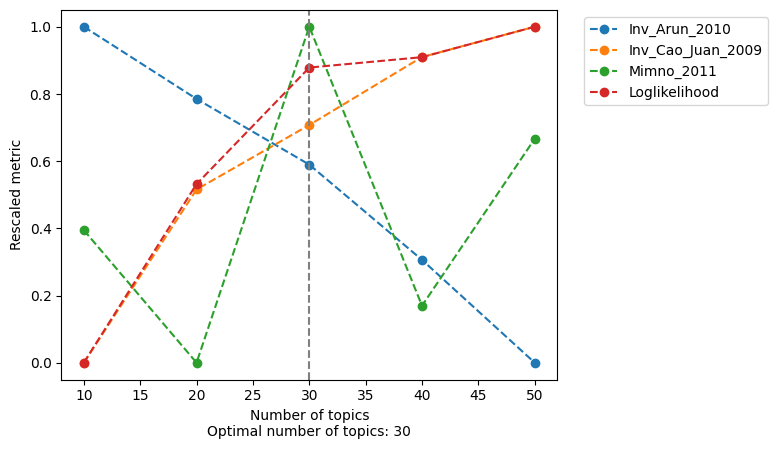

In [9]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    min_topics_coh=0,
    select_model = 30,
    return_model = True
)


In [10]:
pycis_topic_obj = pickle.load(
    open(f"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}.pkl", "rb")
)

In [11]:
pycis_topic_obj.cell_data['ACC:celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')
pycis_topic_obj.cell_data['celltype.L2.condition'] = pycis_topic_obj.cell_data['ACC:celltype.L2.condtion'].astype('category')

In [12]:
pycis_topic_obj.cell_data['celltype.L2.condition'].unique()

['Microglia-2_MC', 'Microglia-1_MC', 'MOL-2_MC', 'MOL-1_MC', 'COP_MC', ..., 'Perivascular_Macrophage_MW', 'Pericyte_MW', 'Immature_cell_MW', 'Lymphocyte_MC', 'Astrocyte-6_MW']
Length: 43
Categories (43, object): ['Arachnoid_Barrier_cell_MC', 'Arachnoid_Barrier_cell_MW', 'Astrocyte-1_MC', 'Astrocyte-1_MW', ..., 'Perivascular_Macrophage_MC', 'Perivascular_Macrophage_MW', 'VLMC_MC', 'VLMC_MW']

In [13]:
# find celltypes condiction counts smaller than 10
atac_small_ct= pycis_topic_obj.cell_data['celltype.L2.condition'].value_counts()[pycis_topic_obj.cell_data['celltype.L2.condition'].value_counts() < 50]

In [14]:
small_union =(sc_small_ct + atac_small_ct).index.tolist()
small_union_l2 = [ "_".join(item.split("_")[:-1]) for item in small_union]
small_union_l2 = list(set(small_union_l2))

In [15]:
small_union_l2

['NFOL',
 'Choroid_plexus_cell',
 'Pericyte',
 'Lymphocyte',
 'Astrocyte-6',
 'Astrocyte-4',
 'Endothelial_cell',
 'Perivascular_Macrophage',
 'Microglia-7',
 'Arachnoid_Barrier_cell',
 'VSMC',
 'Ependymal_cell',
 'OPC-2',
 'Immature_cell',
 'Microglia-6']

In [16]:
atac_tokeep = pycis_topic_obj.cell_data[~pycis_topic_obj.cell_data['ACC:celltype.L2'].isin(small_union_l2)].index

In [17]:
subset_obj = pycis_topic_obj.subset(cells=atac_tokeep, copy=True)

In [18]:
subset_obj.add_LDA_model(model)

In [19]:
subset_obj.cell_data['celltype.L2.condition'] = subset_obj.cell_data['ACC:celltype.L2.condition'].astype('str').astype('category')

In [20]:
adata_sc.obs['GEX:celltype.L2'] = adata_sc.obs['GEX:celltype.L2'].str.replace(' ', '_').str.replace('/', '-')
adata_sc_subset = adata_sc[~adata_sc.obs['GEX:celltype.L2'].isin(small_union_l2)].copy()

In [21]:
adata_sc_subset.obs['celltype.L2.condition'] = adata_sc_subset.obs['celltype.L2.condition'].astype('str').astype('category')

In [22]:
subset_obj.cell_data['celltype.L2.condition'].value_counts()

Microglia-2_MC    1880
Microglia-2_MW    1757
Astrocyte-2_MW    1572
Astrocyte-2_MC    1421
MOL-1_MC          1411
MOL-1_MW          1339
COP_MW             519
MOL-2_MC           510
MOL-2_MW           490
OPC-1_MC           422
Microglia-3_MC     329
OPC-1_MW           320
COP_MC             293
Microglia-3_MW     235
MOL-4_MW           230
Microglia-1_MW     202
MOL-4_MC           184
Microglia-4_MC     168
Microglia-1_MC     161
Microglia-4_MW     118
VLMC_MW            106
Astrocyte-1_MW     105
MFOL_MC             99
MFOL_MW             98
Astrocyte-1_MC      94
VLMC_MC             69
Name: celltype.L2.condition, dtype: int64

In [23]:
pickle.dump(
    subset_obj,
    open(os.path.join('/data1st2/junyi/output/atac0627/cistopic', f"cistopic_{cellltype}_subset.pkl"), "wb")
)


In [24]:
adata_sc_subset.write_h5ad(
    f'/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc_subset.h5ad'
)

... storing 'GEX:celltype.L2' as categorical


In [ ]:
adata_sc_subset.obs['celltype.L2.condition']

Astrocyte-2_MW    2437
Astrocyte-2_MC    2209
MOL-1_MC          2020
MOL-1_MW          1952
OPC-1_MW          1129
Microglia-2_MW    1094
OPC-1_MC          1054
Microglia-2_MC    1023
Microglia-4_MW     947
Microglia-3_MW     820
MOL-2_MC           815
Microglia-3_MC     726
MOL-2_MW           720
Microglia-4_MC     587
MOL-4_MC           516
MOL-4_MW           466
Astrocyte-1_MW     337
Microglia-1_MC     325
Astrocyte-1_MC     323
Microglia-1_MW     291
MFOL_MW            253
MFOL_MC            241
VLMC_MW            220
VLMC_MC            158
COP_MW             129
COP_MC             112
Name: celltype.L2.condition, dtype: int64

In [ ]:
# pycis_topic_obj.add_LDA_model(model)

In [ ]:
# pickle.dump(
#     pycis_topic_obj,
#     open(os.path.join('/data1st2/junyi/output/atac0627/cistopic', f"cistopic_{cellltype}.pkl"), "wb")
# )


In [ ]:
pycis_topic_obj = subset_obj

In [ ]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

In [ ]:
# find_clusters(
#     pycis_topic_obj,
#     target  = 'cell',
#     k = 10,
#     res = [0.6, 1.2, 3],
#     prefix = 'pycisTopic_',
#     scale = True,
#     split_pattern = '-'
# )


In [ ]:
# run_umap(
#     pycis_topic_obj,
#     target  = 'cell', scale=True)


In [ ]:
# plot_metadata(
#     pycis_topic_obj,
#     reduction_name='UMAP',
#     variables=['celltype.L2'],
#     target='cell', num_columns=1,
#     text_size=10,
#     dot_size=5)


In [ ]:
# annot_dict = {}
# for resolution in [0.6, 1.2, 3]:
#     annot_dict[f"pycisTopic_leiden_10_{resolution}"] = {}
#     for cluster in set(pycis_topic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"]):
#         counts = pycis_topic_obj.cell_data.loc[
#             pycis_topic_obj.cell_data.loc[pycis_topic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"] == cluster].index,
#             "celltype.L2"].value_counts()
#         annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"{counts.index[counts.argmax()]}({cluster})"


In [ ]:
# for resolution in [0.6, 1.2, 3]:
#     pycis_topic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'] = [
#         annot_dict[f'pycisTopic_leiden_10_{resolution}'][x] for x in pycis_topic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'].tolist()
#     ]


In [ ]:
# plot_metadata(
#     pycis_topic_obj,
#     reduction_name='UMAP',
#     variables=['celltype.L2', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'celltype.L3'],
#     target='cell', num_columns=4,
#     text_size=10,
#     dot_size=5)


In [ ]:
# plot_topic(
#     pycis_topic_obj,
#     reduction_name = 'UMAP',
#     target = 'cell',
#     num_columns=5
# )


In [ ]:
# if isinstance(pycis_topic_obj.cell_data.index, pd.MultiIndex):
#     pycis_topic_obj.cell_data = pycis_topic_obj.cell_data.reset_index()


In [ ]:
# pycis_topic_obj.cell_data['celltype.L2'] = pycis_topic_obj.cell_data['celltype.L2'].astype('str')pycis_topic_obj.cell_data['celltype.L2'].astype('str').replace("Hippo_","")
pycis_topic_obj.cell_data['celltype.L2str'] = pycis_topic_obj.cell_data['celltype.L2'].astype('str')
pycis_topic_obj.cell_data['C'] = pycis_topic_obj.cell_data['condtion'].astype('str')

In [ ]:
cell_topic_heatmap(
    pycis_topic_obj,
    variables = ['celltype.L2str'],
    scale = False,
    legend_loc_x = 0.98,
    legend_loc_y = -1.2,
    legend_dist_y = -1.5,
    figsize = (15, 12),
)


In [ ]:
from pycisTopic.topic_binarization import binarize_topics
region_bin_topics_top_3k = binarize_topics(
    pycis_topic_obj, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)


In [ ]:
region_bin_topics_otsu = binarize_topics(
    pycis_topic_obj, method='otsu',
    plot=True, num_columns=5
)


In [ ]:
binarized_cell_topic = binarize_topics(
    pycis_topic_obj,
    target='cell',
    method='li',
    plot=True,
    num_columns=5, nbins=100)


In [ ]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img


In [ ]:
topic_qc_metrics = compute_topic_metrics(pycis_topic_obj)


In [ ]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)


In [ ]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()


In [ ]:
topic_annot = topic_annotation(
    pycis_topic_obj,
    annot_var='celltype.L2',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)


In [ ]:
import os

out_dir = f'/data1st2/junyi/output/atac0627/cistopic/{cellltype}'

if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
if not os.path.exists(os.path.join(out_dir, "region_sets")):
    os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok=True)


os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARsL2"), exist_ok=True)



In [ ]:
from pycisTopic.utils import region_names_to_coordinates


In [ ]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )


In [ ]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
scenic_dir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}'

In [ ]:
df_dar= pd.read_csv(
    '/data2st1/junyi/output/atac0627/dar/region_nt/mementob_dar_ncelltype.csv')

In [ ]:
map_up = {"MC":"Up",'MW':"Down"}
df_dar['regulation'] = df_dar['condition'].replace(map_up).astype('category')

In [ ]:
if ctname.find('NN') != -1:
    df_dar_UP = df_dar.loc[
        (~df_dar['ctname'].str.contains('_G')) & (df_dar['regulation'] == 'Up')
    ]
else:
    df_dar_UP = df_dar.loc[
    (df_dar['ctname'] == ctname) & (df_dar['regulation'] == 'Up')
    ]
df_dar_bed = df_dar_UP.names.str.split(r'[:-]',expand=True)
df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)
df_dar_bed.sort_values(
    [0, 1, 2]
).to_csv(
    os.path.join(out_dir, "region_sets", "DARs", f"CUMS_Up.bed"),
    sep = "\t",
    header = False, index = False
)

In [ ]:
if ctname.find('NN') != -1:
    df_dar_DOWN = df_dar.loc[
        (~df_dar['ctname'].str.contains('_G')) & (df_dar['regulation'] == 'Down')
    ]
else:
    df_dar_DOWN = df_dar.loc[
    (df_dar['ctname'] == ctname) & (df_dar['regulation'] == 'Down')
    ]
df_dar_bed = df_dar_DOWN.names.str.split(r'[:-]',expand=True)
df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)
df_dar_bed.sort_values(
    [0, 1, 2]
).to_csv(
    os.path.join(out_dir, "region_sets", "DARs", f"CUMS_Down.bed"),
    sep = "\t",
    header = False, index = False
)

In [ ]:
# df_darl2= pd.read_csv(
#     '/data2st1/junyi/output/atac0627/dar/celltype.L2/mementob_dar_ncelltype.csv')
# map_up = {"MC":"Up",'MW':"Down"}
# df_darl2['regulation'] = df_darl2['condition'].replace(map_up).astype('category')
# df_darl2_UP = df_darl2.loc[
#     (df_darl2['ctname'] == ctname) & (df_darl2['regulation'] == 'Up')
# ]
# df_darl2_bed = df_darl2_UP.names.str.split(r'[:-]',expand=True)


In [ ]:
# df_darl2

In [ ]:
# df_darl2_bed.iloc[:, 1] = df_darl2_bed.iloc[:, 1].astype(int)
# df_darl2_bed.iloc[:, 2] = df_darl2_bed.iloc[:, 2].astype(int)
# df_darl2_bed.sort_values(
#     [0, 1, 2]   
# ).to_csv(
#     os.path.join(out_dir, "region_sets", "DARsL2", f"CUMS_Up.bed"),
#     sep = "\t",
#     header = False, index = False
# )
# df_darl2_DOWN = df_darl2.loc[
#     (df_darl2['ctname'] == ctname) & (df_darl2['regulation'] == 'Down')
# ]
# df_darl2_bed = df_darl2_DOWN.names.str.split(r'[:-]',expand=True)
# df_darl2_bed.iloc[:, 1] = df_darl2_bed.iloc[:, 1].astype(int)
# df_darl2_bed.iloc[:, 2] = df_darl2_bed.iloc[:, 2].astype(int)
# df_darl2_bed.sort_values(
#     [0, 1, 2]
# ).to_csv(
#     os.path.join(out_dir, "region_sets", "DARsL2", f"CUMS_Down.bed"),
#     sep = "\t",
#     header = False, index = False
# )   

In [ ]:
!cd {scenic_dir}
!scenicplus init_snakemake --out_dir {scenic_dir}

input_data:  
  cisTopic_obj_fname: "/data1st2/junyi/output/atac0627/cistopic/cistopic_HIP_HIP_Glut.pkl"
  GEX_anndata_fname: "/data1st2/junyi/output/atac0627/subset/region_nt/HIP_HIP_Glut_sc.h5ad"
  region_set_folder: "/data1st2/junyi/output/atac0627/cistopic/HIP_HIP_Glut/region_sets/"
  ctx_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather"
  dem_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather"
  path_to_motif_annotations: "/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

params_general:
  temp_dir: "/data1st2/junyi/output/atac0627/scenic/HIP_HIP_Glut/"
  n_cpu: 32

params_data_preparation:
  # Params for prepare_GEX_ACC
  is_multiome: False
  key_to_group_by: "celltype.L2"
  species: "mmusculus"
  biomart_host: "http://nov2020.archive.ensembl.org"

  species: "mus_musculus"


In [ ]:
import shutil


In [ ]:
# backup the config.yaml file
for region in ['AMY', 'HIP', 'PFC']:
    for nt in ['GABA', 'Glut', 'NN']:
        ctname = f'{region}_{nt}'
        if nt == 'NN':
            cellltype = f'{region}_{nt}'
        else:
            cellltype = f'{region}_{region}_{nt}'
        scenic_dir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}'
        out_dir = f'/data1st2/junyi/output/atac0627/cistopic/{cellltype}'

        shutil.copyfile(os.path.join(scenic_dir,'Snakemake','config', "config.yaml"),
                        os.path.join(scenic_dir,'Snakemake','config', "config.yaml.bak"))
        # read yaml file line by line and change the
        with open(os.path.join(scenic_dir,'Snakemake','config', "config.yaml"), 'r') as file:
            lines = file.readlines()
        # config['input_data']['cisTopic_obj_fname'] = f"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}.pkl"
        # config['input_data']['GEX_anndata_fname'] = f"/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad"
        # config['input_data']['region_set_folder'] = os.path.join(out_dir, "region_sets")
        # config['input_data']['ctx_db_fname'] = "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather"
        # config['input_data']['dem_db_fname'] = "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather"
        # config['input_data']['path_to_motif_annotations'] = "/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

        # config['params_general']['temp_dir'] = scenic_dir
        # config['params_general']['n_cpu'] = 32
        # config['params_data_preparation']['species'] = "mus_musculus"
        # config['params_data_preparation']['key_to_group_by'] = "celltype.L2"
        # config['params_data_preparation']['is_multiome'] = False
        # config['params_data_preparation']['biomart_host'] = "http://nov2020.archive.ensembl.org"
        # config['params_motif_enrichment']['species'] = "mus_musculus"

        section = 'input_data'
        for l in range(len(lines)):
            if 'input_data' in lines[l]:
                section = 'input_data'
            elif 'output_data' in lines[l]:
                section = 'output_data'
            elif 'params_general' in lines[l]:
                section = 'params_general'
            elif 'params_data_preparation' in lines[l]:
                section = 'params_data_preparation'
            elif 'params_motif_enrichment' in lines[l]:
                section = 'params_motif_enrichment'

            if 'cisTopic_obj_fname' in lines[l]:
                lines[l] = f"  cisTopic_obj_fname: \"/data1st2/junyi/output/atac0627/cistopic/cistopic_{cellltype}.pkl\"\n"
            elif 'GEX_anndata_fname' in lines[l]:
                lines[l] = f"  GEX_anndata_fname: \"/data1st2/junyi/output/atac0627/subset/region_nt/{cellltype}_sc.h5ad\"\n"
            elif 'region_set_folder' in lines[l]:
                lines[l] = f"  region_set_folder: \"{os.path.join(out_dir, 'region_sets')}\"\n"
            elif 'ctx_db_fname' in lines[l]:
                lines[l] = f"  ctx_db_fname: \"/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather\"\n"
            elif 'dem_db_fname' in lines[l]:
                lines[l] = f"  dem_db_fname: \"/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather\"\n"
            elif 'path_to_motif_annotations' in lines[l]:
                lines[l] = f"  path_to_motif_annotations: \"/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl\"\n"
            elif 'temp_dir' in lines[l]:
                lines[l] = f"  temp_dir: \"{scenic_dir}\"\n"
            elif 'n_cpu' in lines[l]:
                lines[l] = f"  n_cpu: 32\n"
            elif 'species' in lines[l] and section == 'params_data_preparation':
                lines[l] = f"  species: \"mmusculus\"\n"
            elif 'key_to_group_by' in lines[l] and section == 'params_data_preparation':
                lines[l] = f"  key_to_group_by: \"celltype.L2.condition\"\n"
            elif 'is_multiome' in lines[l] and section == 'params_data_preparation':
                lines[l] = f"  is_multiome: False\n"
            elif 'biomart_host' in lines[l] and section == 'params_data_preparation':
                lines[l] = f"  biomart_host: \"http://nov2020.archive.ensembl.org\"\n"
            elif 'species' in lines[l] and section == 'params_motif_enrichment':
                lines[l] = f"  species: \"mus_musculus\"\n"

        with open(os.path.join(scenic_dir,'Snakemake','config', "config.yaml"), 'w') as file:
            file.writelines(lines)

In [ ]:
os.path.join(scenic_dir,'Snakemake','config', "config.yaml")